`Dragonnet` requires `tensorflow`. If you haven't, please install `tensorflow` as follows:
```
pip install tensorflow
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-08-25 12:58:41.823350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Failed to import duecredit due to No module named 'duecredit'


# IHDP semi-synthetic dataset

Hill introduced a semi-synthetic dataset constructed from the Infant Health
and Development Program (IHDP). This dataset is based on a randomized experiment
investigating the effect of home visits by specialists on future cognitive scores. The data has 747 observations (rows). The IHDP simulation is considered the de-facto standard benchmark for neural network treatment effect
estimation methods.

The original [paper](https://arxiv.org/pdf/1906.02120.pdf) uses 1000 realizations from the NCPI package, but for illustration purposes, we use 1 dataset (realization) as an example below. 

In [3]:
df = pd.read_csv(f'data/ihdp_npci_3.csv', header=None)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f'x{i}' for i in range(1,26)]
df.columns = cols

In [4]:
df.shape

(747, 30)

In [5]:
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.931652,3.500591,2.253801,7.136441,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,2.175966,5.952101,1.257592,6.553022,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.180294,7.175734,2.384100,7.192645,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,3.587662,7.787537,4.009365,7.712456,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,2.372618,5.461871,2.481631,7.232739,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [6]:
pd.Series(df['treatment']).value_counts(normalize=True)

0    0.813922
1    0.186078
Name: treatment, dtype: float64

In [7]:
X = df.loc[:,'x1':]
treatment = df['treatment']
y = df['y_factual']
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)

In [8]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [9]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 747, number of used features: 26
[LightGBM] [Info] Start training from score 4.046921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [10]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
10/10 [==============================] - 3s 56ms/step - loss: 1213.8274 - regression_loss: 545.5735 - binary_classification_loss: 42.5535 - treatment_accuracy: 0.3618 - track_epsilon: 0.0715 - val_loss: 267.5876 - val_regression_loss: 99.0472 - val_binary_classification_loss: 33.9823 - val_treatment_accuracy: 0.6534 - val_track_epsilon: 0.0722 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 0s 7ms/step - loss: 342.0785 - regression_loss: 148.3811 - binary_classification_loss: 34.3580 - treatment_accuracy: 0.8313 - track_epsilon: 0.0719 - val_loss: 245.1353 - val_regression_loss: 85.6349 - val_binary_classification_loss: 32.4010 - val_treatment_accuracy: 0.7244 - val_track_epsilon: 0.0729 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 0s 8ms/step - loss: 275.3210 - regression_loss: 112.0703 - binary_classification_loss: 27.5068 - treatment_accuracy: 0.8465 - track_epsilon: 0.0728 - val_loss: 235.7980 - val_regression_loss: 80.5627 - val_bina

In [11]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          tau.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','tau','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [12]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau.mean()],
                     index=['S','T','X','R','dragonnet','actual'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite, t_ite, x_ite, r_ite, dragon_ite],
                                                            [tau.values.reshape(-1,1)]*5 )
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)

In [13]:
df_result

,ATE,MAE,AUUC
S,4.054511,1.027666,0.575822
T,4.100199,0.980788,0.580929
X,4.020918,1.116303,0.564651
R,3.928322,1.805783,0.552784
dragonnet,3.981136,1.196805,0.552498
actual,4.098887,NaN,NaN


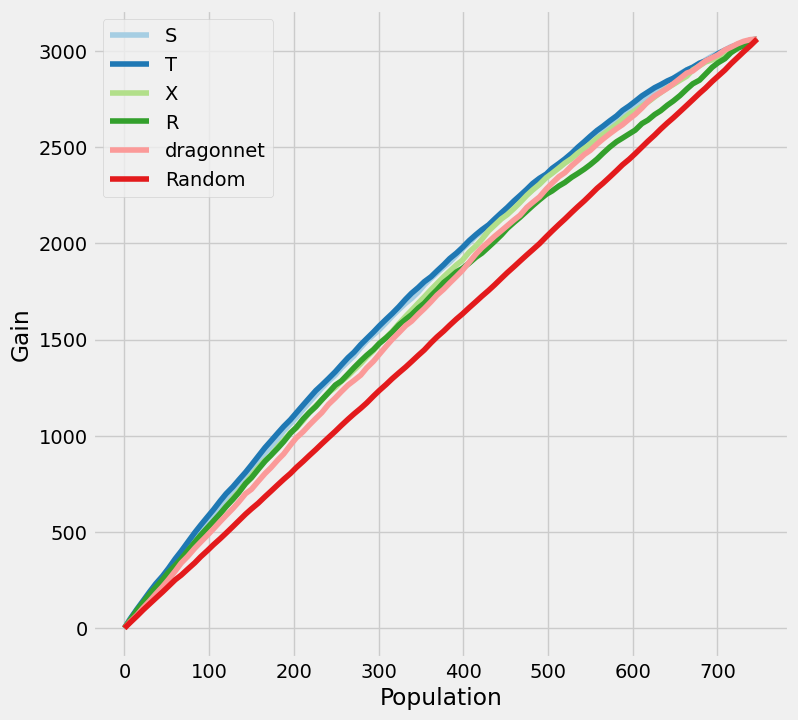

In [14]:
plot_gain(df_preds)

# `causalml` Synthetic Data Generation Method

In [15]:
y, X, w, tau, b, e = simulate_nuisance_and_easy_treatment(n=1000)

X_train, X_val, y_train, y_val, w_train, w_val, tau_train, tau_val, b_train, b_val, e_train, e_val = \
    train_test_split(X, y, w, tau, b, e, test_size=0.2, random_state=123, shuffle=True)

preds_dict_train = {}
preds_dict_valid = {}

preds_dict_train['Actuals'] = tau_train
preds_dict_valid['Actuals'] = tau_val

preds_dict_train['generated_data'] = {
    'y': y_train,
    'X': X_train,
    'w': w_train,
    'tau': tau_train,
    'b': b_train,
    'e': e_train}
preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'w': w_val,
    'tau': tau_val,
    'b': b_val,
    'e': e_val}

# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat_train = p_model.fit_predict(X_train, w_train)
p_hat_val = p_model.fit_predict(X_val, w_val)

for base_learner, label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],
                                 ['S', 'T', 'X', 'R']):
    for model, label_m in zip([LinearRegression, XGBRegressor], ['LR', 'XGB']):
        # RLearner will need to fit on the p_hat
        if label_l != 'R':
            learner = base_learner(model())
            # fit the model on training data only
            learner.fit(X=X_train, treatment=w_train, y=y_train)
            try:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, p=p_hat_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, p=p_hat_val).flatten()
            except TypeError:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, treatment=w_train, y=y_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, treatment=w_val, y=y_val).flatten()
        else:
            learner = base_learner(model())
            learner.fit(X=X_train, p=p_hat_train, treatment=w_train, y=y_train)
            preds_dict_train['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_train).flatten()
            preds_dict_valid['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_val).flatten()

learner = DragonNet(verbose=False)
learner.fit(X_train, treatment=w_train, y=y_train)
preds_dict_train['DragonNet'] = learner.predict_tau(X=X_train).flatten()
preds_dict_valid['DragonNet'] = learner.predict_tau(X=X_val).flatten()

7/7 [==============================] - 0s 6ms/step


In [16]:
actuals_train = preds_dict_train['Actuals']
actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_train = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_train)] for label, preds
                                        in preds_dict_train.items() if 'generated' not in label.lower()},
                                       index=['ATE', 'MSE']).T
synthetic_summary_train['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_train['ATE']/synthetic_summary_train.loc['Actuals', 'ATE']) - 1)

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for training
for label in synthetic_summary_train.index:
    stacked_values = np.hstack((preds_dict_train[label], actuals_train))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_train[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_train, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_train.loc[label, 'KL Divergence'] = kl

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl

In [17]:
df_preds_train = pd.DataFrame([preds_dict_train['S Learner (LR)'].ravel(),
                               preds_dict_train['S Learner (XGB)'].ravel(),
                               preds_dict_train['T Learner (LR)'].ravel(),
                               preds_dict_train['T Learner (XGB)'].ravel(),
                               preds_dict_train['X Learner (LR)'].ravel(),
                               preds_dict_train['X Learner (XGB)'].ravel(),
                               preds_dict_train['R Learner (LR)'].ravel(),
                               preds_dict_train['R Learner (XGB)'].ravel(),                               
                               preds_dict_train['DragonNet'].ravel(),
                               preds_dict_train['generated_data']['tau'].ravel(),
                               preds_dict_train['generated_data']['w'].ravel(),
                               preds_dict_train['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'DragonNet','tau','w','y']).T

synthetic_summary_train['AUUC'] = auuc_score(df_preds_train).iloc[:-1]



In [18]:
df_preds_validation = pd.DataFrame([preds_dict_valid['S Learner (LR)'].ravel(),
                               preds_dict_valid['S Learner (XGB)'].ravel(),
                               preds_dict_valid['T Learner (LR)'].ravel(),
                               preds_dict_valid['T Learner (XGB)'].ravel(),
                               preds_dict_valid['X Learner (LR)'].ravel(),
                               preds_dict_valid['X Learner (XGB)'].ravel(),
                               preds_dict_valid['R Learner (LR)'].ravel(),
                               preds_dict_valid['R Learner (XGB)'].ravel(),                               
                               preds_dict_valid['DragonNet'].ravel(),
                               preds_dict_valid['generated_data']['tau'].ravel(),
                               preds_dict_valid['generated_data']['w'].ravel(),
                               preds_dict_valid['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'DragonNet','tau','w','y']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]

In [19]:
synthetic_summary_train

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.484486,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.528743,0.044194,0.091349,3.473087,0.507758
S Learner (XGB),0.358208,0.310652,0.260643,0.817620,0.544115
T Learner (LR),0.493815,0.022688,0.019255,0.289978,0.610855
T Learner (XGB),0.397053,1.350928,0.180466,1.452143,0.521719
X Learner (LR),0.493815,0.022688,0.019255,0.289978,0.610855
X Learner (XGB),0.341352,0.620992,0.295435,1.086086,0.534827
R Learner (LR),0.457692,0.028116,0.055304,0.335083,0.614414
R Learner (XGB),0.434709,4.575591,0.102741,1.907325,0.505088
DragonNet,0.443478,0.043764,0.084642,0.457552,0.613330


In [20]:
synthetic_summary_validation

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.511242,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.528743,0.042236,0.034233,4.574498,0.502284
S Learner (XGB),0.434208,0.260496,0.150680,0.854890,0.544206
T Learner (LR),0.541503,0.025840,0.059191,0.686602,0.604712
T Learner (XGB),0.483404,0.679398,0.054452,1.215394,0.526918
X Learner (LR),0.541503,0.025840,0.059191,0.686602,0.604712
X Learner (XGB),0.330427,0.344865,0.353678,1.227041,0.536599
R Learner (LR),0.510236,0.030801,0.001967,0.654228,0.608133
R Learner (XGB),0.417823,1.990451,0.182730,1.650560,0.504991
DragonNet,0.497455,0.045204,0.026968,0.799372,0.607606


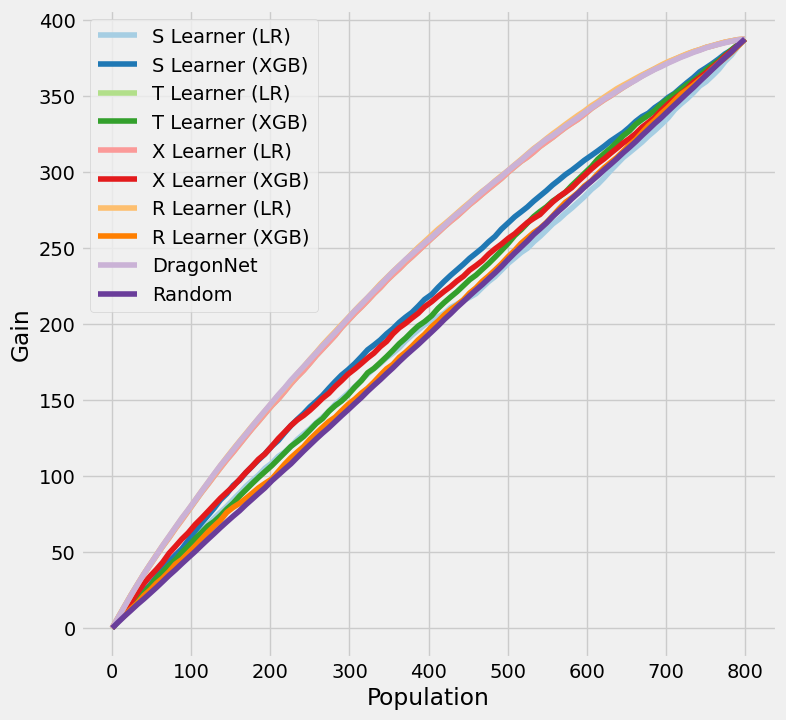

In [21]:
plot_gain(df_preds_train)

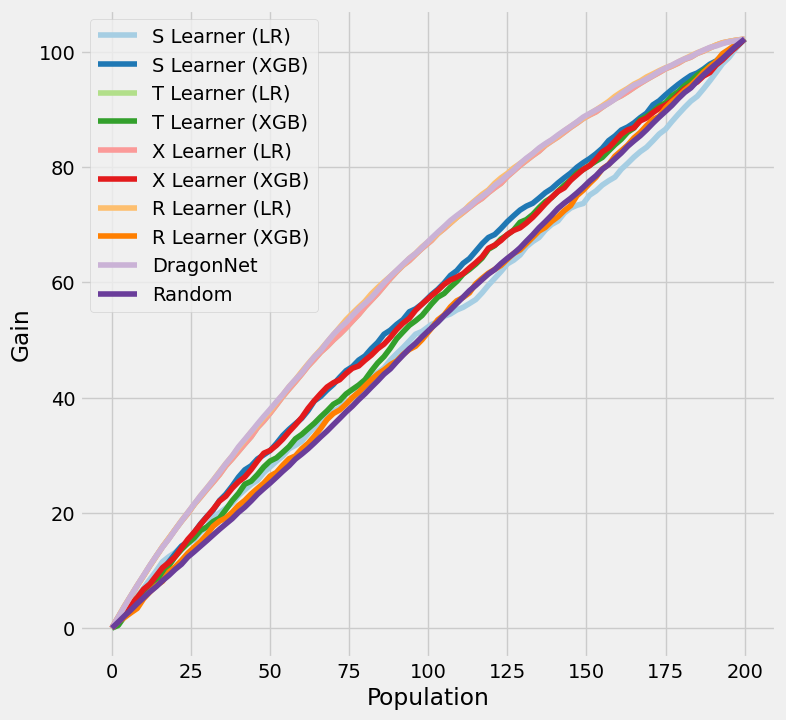

In [22]:
plot_gain(df_preds_validation)